# Fly Hemibrain

Playing around with some basic connectome data, from the [Fly Hemibrain](https://www.janelia.org/project-team/flyem/hemibrain) project. If you scroll down that page a little, under the heading "Resources and relevant technologies", the first link "Compact connection matrix summary" is a zip file with three `.csv` files (and a useful README), those files need to be moved into the directory `/notebooks/hemibrain/exported-traced-adjacencies/` for this script. I didn't want to post those files to a public github repo since (a) they're not my data and (b) they're like, a few hundred megabytes in total.

In [1]:
"""Playing around with the fly hemibrain data"""

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time

## Load the graph

In [2]:
# Step 1: Just reading some csv files and attempting to make a networkx graph

directory = "/notebooks/nx_graph_utils/hemibrain/exported-traced-adjacencies/"

print("Attempting to read files in directory", directory)

nodes_file = "traced-neurons.csv"
edges_file = "traced-total-connections.csv"

edge_data = open(directory+edges_file, "r")
next(edge_data, None)  # skip the first line of the file, which is just a header row

t_start = time.time()
FlyBrain = nx.parse_edgelist(edge_data, delimiter=",", create_using=nx.DiGraph, nodetype=int, data=[("n_synapses", int)])
t_end = time.time()

print("Read in {} nodes and {} edges in {} s".format(nx.number_of_nodes(FlyBrain), nx.number_of_edges(FlyBrain), t_end-t_start))


print(nx.info(FlyBrain))

Attempting to read files in directory /notebooks/hemibrain/exported-traced-adjacencies/
Read in 21662 nodes and 3413160 edges
Name: 
Type: DiGraph
Number of nodes: 21662
Number of edges: 3413160
Average in degree: 157.5644
Average out degree: 157.5644


It can take a while to run computations, so be choosy about what you try to run. Also, the adjacency matrix is 20k x 20k, so don't try to naively take third powers of it.

In [3]:
from nx_graph_utils.graphstatistics import linearalgebra

# linearalgebra.nfftriads(FlyBrain)  # Kills the notebook kernel, at least on my laptop.

t_start = time.time()
trans_flybrain = nx.transitivity(FlyBrain)
t_end = time.time()
print("Computed transitivity: {}".format(trans_flybrain))
print("Computation took {} s".format(t_end - t_start))

Computed transitivity: 0.16152591521646892
Computation took 186.56738376617432 s


## Assortativity

The assortivity coefficient is the correlation coefficient between the degrees of nodes joined by an edge. To elaborate, we think of two random variables X and Y which represent the degree of each node, and each edge represents one sample. We're computing the correlation coefficient between X and Y across all edges.

The unweighted case treats all edges equally (i.e. all edges have weight 1). In the weighted case, the number of synapses between the pre- and post-synaptic neurons weights the contribution of each edge.

In [4]:
print("Computing assortativity coefficient...")
t_start = time.time()
assort_in_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in")
t_end = time.time()
print("Got in-degree/in-degree assortavity coefficient of {} in {} s".format(assort_in_in, t_end - t_start))
assort_in_out = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out")
assort_out_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in")
assort_out_out =nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{assort_in_in:<16.10f}{assort_in_out:<16.10f}")
print(f"{'out':<17}|{assort_out_in:<16.10f}{assort_out_out:<16.10f}")

Computing assortativity coefficient...
Got in-degree/in-degree assortavity coefficient of 0.021227025736457995 in 14.3770432472229 s
Assortativity Coefficients:
 v sink, source >|in              out             
--------------------------------------------------
in               |0.0212270257    0.0132345597    
out              |-0.0223338001   -0.0096649372   


In [5]:
wt_ass_ii = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in", weight="n_synapses")
wt_ass_io = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out", weight="n_synapses")
wt_ass_oi = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in", weight="n_synapses")
wt_ass_oo = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out", weight="n_synapses")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{wt_ass_ii:<16.10f}{wt_ass_io:<16.10f}")
print(f"{'out':<17}|{wt_ass_oi:<16.10f}{wt_ass_oo:<16.10f}")

KeyboardInterrupt: 

## Plots
Let's try some basic plotting

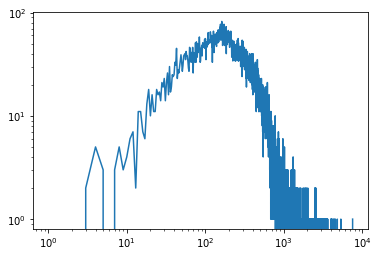

In [4]:
plt.loglog(nx.degree_histogram(FlyBrain))  # degree = in-degree + out-degree, not the most useful

In [7]:
FlyBrain.in_degree[5813054846]

223

In [10]:
in_out = [(FlyBrain.in_degree[v], FlyBrain.out_degree[v]) for v in FlyBrain.nodes]
print(in_out[:5])
plt.scatter(in_out)

[(223, 123), (100, 145), (92, 80), (452, 51), (83, 166)]


TypeError: scatter() missing 1 required positional argument: 'y'

In [12]:
def degrees_by_edges(G, weight_threshold=0, weight_name="weight"):
    """Return an m x 4 numpy array, where m is the number of edges.
    Each row represents a distinct edge, and the columns are (in order):
    pre_in, pre_out, post_in, post_out
    That is, the in-degree and out-degree of the pre- and post-synatpic neuron of each edge.
    
    Ignores edges where edge attribute `weight_name` is strictly less than weight_threshold"""
    pass
## Poking around in the networkx docs has revealed this function is already implemented, here: 